<a href="https://colab.research.google.com/github/proppy/sscs-ose-code-a-chip.github.io/blob/proppy-amp/ISSCC24/submitted_notebooks/minimalfab-commonsourceamp/minimalfab-commonsourceamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Common Source Amplifier for Minimal Fab

```
Copyright 2023 Google LLC.
SPDX-License-Identifier: Apache-2.0
```

Programmatically design a common source amplifier on top of a  [Minimal Fab PDK](https://github.com/mineda-support/ICPS2023_5) base layout pre-populated with nmos and pmos devices.

Design found in [Fifty Nifty Variations of Two-Transistor Circuits: A tribute to the versatility of MOSFETs
](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9523464) (Fig10).

Originally submitted to [Minimal Fab Design contest for SemiCon Japan 2023](https://github.com/mineda-support/Semicon2023-MinimalFab-Design-Contest).

## Pins

- Power: `pin22`
- Ground: `pin26`
- Inputs:
  - `Vbias`: `pin23`
  - `Vin`: `pin25`
- Ouputs:
  - `Vout`: `pin24`

In [1]:
#@title Install dependencies
#@markdown - [klayout python bindings](https://pypi.org/project/klayout/) form PyPi
#@markdown - klayout and ngspice cli from [conda-eda](https://github.com/hdl/conda-eda)
#@markdown - Minimal Fab's [PDK](https://github.com/mineda-support/ICPS2023_5), examples and [support scripts](https://github.com/mineda-support/AnagixLoader) from GitHub.

!python -m pip install klayout
!git clone https://github.com/mineda-support/ICPS2023_5
# prevent extraction warnings
!rm ICPS2023_5/Technology/tech/macros/pcells_v0.1.lym
!curl -L -O https://repo.anaconda.com/miniconda/Miniconda3-py310_23.10.0-1-Linux-x86_64.sh
!bash Miniconda3-py310_23.10.0-1-Linux-x86_64.sh -b -p minimal-env/
!minimal-env/bin/conda install -yq litex-hub::klayout litex-hub::ngspice
!git clone https://github.com/mineda-support/AnagixLoader
!mkdir -p /root/.klayout/salt
!ln -sf $(readlink -f AnagixLoader) /root/.klayout/salt/AnagixLoader
!ln -sf $(readlink -f ICPS2023_5) /root/.klayout/salt/ICPS2023_5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.6/22.6 MB 33.0 MB/s eta 0:00:00
Cloning into 'ICPS2023_5'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (199/199), done.
remote: Total 404 (delta 215), reused 377 (delta 191), pack-reused 0
Receiving objects: 100% (404/404), 3.21 MiB | 22.34 MiB/s, done.
Resolving deltas: 100% (215/215), done.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  108M  100  108M    0     0   154M      0 --:--:-- --:--:-- --:--:--  154M
PREFIX=/content/minimal-env
Unpacking payload ...

Installing base environment...





Preparing transaction: - \ | / - \ | / - done
Executing transaction: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
installation finished.
    You currently have a PYTHONPATH en

## Route Layout

Using [Python KLayout API](https://pypi.org/project/klayout) w/ hardcoded position and waypoints.

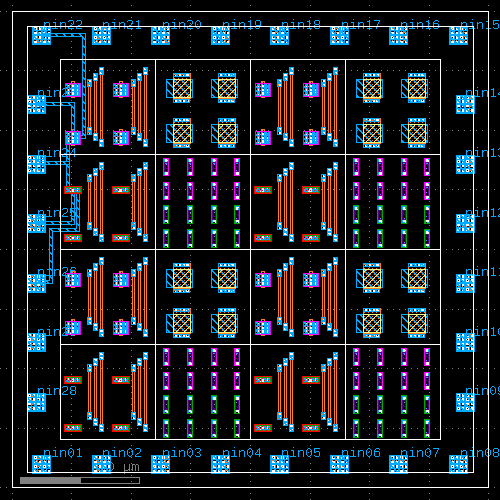

In [2]:
import klayout.db as db # necessary to get the gds plugin loaded
import klayout.lay as lay
import IPython.display

db.Technology.clear_technologies()
tech = db.Technology.create_technology('ICPS2023_5')
tech.load('ICPS2023_5/Technology/tech/tech.lyt')

lv = lay.LayoutView()
lv.load_layout('ICPS2023_5/Samples/Semicon2023/base_contest2023.GDS')
lv.max_hier()
ly = lv.active_cellview().layout()
top_cell = ly.top_cell()
layers = {l.name: l for l in lv.each_layer()}
ml1_layer = top_cell.shapes(layers['ML1'].layer_index())
path_width = 10000
pin22 = db.Point(-700000, 720000)
pin23 = db.Point(-720000, 490000)
pin24 = db.Point(-720000, 290000)
pin25 = db.Point(-720000, 90000)
pin26 = db.Point(-720000, -110000)
pmos2 = [
    db.Point(-614000, 377000),
    db.Point(-595000, 377000),
    db.Point(-578000, 377000)
]
nmos1 = [
    db.Point(-614000, 200000),
    db.Point(-595000, 200000),
    db.Point(-578000, 200000)
]
waypoint22_x = -560000
ml1_layer.insert(db.Path([
    pin22, db.Point(waypoint22_x, pin22.y),
    db.Point(waypoint22_x, pmos2[2].y), pmos2[2]
    ], path_width))
ml1_layer.insert(db.Path([pin23, db.Point(pmos2[1].x, pin23.y), pmos2[1]], path_width))
ml1_layer.insert(db.Path([pin24, db.Point(pmos2[0].x, pin24.y), pmos2[0]], path_width))
ml1_layer.insert(db.Path([pin24, db.Point(nmos1[0].x, pin24.y), nmos1[0]], path_width))
ml1_layer.insert(db.Path([pin25, db.Point(nmos1[1].x, pin25.y), nmos1[1]], path_width))
waypoint26_x = -670000
waypoint26_y = 65000
ml1_layer.insert(db.Path([
    pin26, db.Point(waypoint26_x, pin26.y),
    db.Point(waypoint26_x, waypoint26_y),
    db.Point(nmos1[2].x, waypoint26_y), nmos1[2]
    ], path_width))
lv.active_cellview().cell_name = top_cell.name
lv.zoom_fit()
lv.timer()
lv.save_as(0, 'proppy-amp.gds', db.SaveLayoutOptions())
display(IPython.display.Image(lv.get_pixels_with_options(500, 500).to_png_data()))

## Extract netlist from layout

By dry-running LVS script and massaging the resulting netlist to match ngspice conventions.

In [3]:
!minimal-env/bin/klayout -zz -nn ICPS2023_5/Technology/tech/tech.lyt -r ICPS2023_5/Technology/tech/lvs/lvs.lylvs proppy-amp.gds
import re

with open('proppy-amp_output.cir', 'r') as f:
  klayout_netlist = f.read()

def klayout2spice(nl):
  # add terminal
  nl = nl.replace('SUBCKT base_Rev0.93', 'SUBCKT base_Rev0.93 1 2 3 4 5')
  # fix model names
  nl = nl.replace('NMOS L=', 'nch L=')
  nl = nl.replace('PMOS L=', 'pch L=')
  # comment unused devices
  nl = re.sub(r'X\$3[012]', '* \g<0>', nl)
  nl = re.sub(r'X\$[124].*Nch', '* \g<0>', nl)
  nl = re.sub(r'X\$[123].*Pch', '* \g<0>', nl)
  # reorder pins
  nl = nl.replace('M$1 2 3 1 1', 'M$1 1 3 2 2')
  return nl

spice_netlist = klayout2spice(klayout_netlist)
print(spice_netlist)

with open('proppy-amp_output.spice', 'w') as f:
  f.write(spice_netlist)

Caution: Please run Backannotation device parasitics in each PDK!
settings file: ./lvs_work/proppy-amp_lvs_settings.rb
0.0
base_Rev0.93
devices_count = 0
base_array
devices_count = 0
pmos_array
devices_count = 0
Pch$1
devices_count = 1
[0, "$1", "PMOS", [10.0, 40.0], "r0 *1 24,37"]
nmos_array
devices_count = 0
Nch$1
devices_count = 1
[0, "$1", "NMOS", [10.0, 10.0], "r0 *1 24,23.5"]
R_ndiff
devices_count = 1
R_pdiff$1
devices_count = 1
cap_con
devices_count = 0
TIN_cap
devices_count = 1
proppy-amp_table.yaml created under /content
/content
./proppy-amp_output.cir
* Created by KLayout

* cell cap_con
.SUBCKT cap_con
* cell instance $1 r0 *1 -43.75,-38.5
X$1 1 TIN_cap
.ENDS cap_con

* cell R_pdiff$1
.SUBCKT R_pdiff$1
* device instance $1 r0 *1 6.5,28 PRES
R$1 2 1 3600 PRES
.ENDS R_pdiff$1

* cell R_ndiff
.SUBCKT R_ndiff
* device instance $1 r0 *1 6.5,28 NRES
R$1 2 1 540 NRES
.ENDS R_ndiff

* cell base_Rev0.93
.SUBCKT base_Rev0.93 1 2 3 4 5
* cell instance $1 r0 *1 -320,320
X$1 5 4 3 3 2 1

## Simulate extracted netlist

Using [ngspice](https://ngspice.sourceforge.io/) and plot the resulting data with [pandas](https://pandas.pydata.org/).


Note: No compatibility mode selected!


Circuit: 

Warning -- Version not specified on line "tnom=25 level=8 paramchk=1 mobmod=1 capmod=3 fnoimod=1 soimod=3 tox=1.5e-08 xj=1.5e-007 nch=1.7e+017 vth0=0.20809 k1=0.5 k2=0 k3=80 k3b=0 w0=2.5e-006 nlx=1.74e-007 vbm=-3.0 dvt0=2.2 dvt1=0.53 dvt2=-0.032 dvt0w=0 dvt1w=5.3e+006 dvt2w=-0.032 u0=670 ua=2.25e-09 ub=5.87e-19 uc=-4.65e-11 vsat=800755.2814 a0=1.1164 ags=0.2656 b0=0 b1=0 keta=-0.047 a1=0 a2=0.20782 rdsw=0 prwb=0 prwg=58.7371 wr=1 wint=0 lint=0 dwg=0 dwb=0 voff=-0.17284 nfactor=0.99099 eta0=0.08 etab=-0.07 dsub=0.56 cit=0 cdsc=0.00021654 cdscb=0 cdscd=0.38995 pclm=2.9694 pdiblc1=0.39 pdiblc2=0.0021218 pdiblcb=0 drout=0.56 pvag=0 delta=0.045152 ngate=0 alpha0=0 beta0=30 rsh=0 xpart=1 cgso=5.3e-9 cgdo=5.3e-9 cgsl=0 cgdl=0 cjswg=5.0e-010 mjswg=0.33 pbswg=1 ckappa=0.6 cf=0 clc=1.0e-007 cle=0.6 dlc=0 dwc=0 noff=1 acde=1 moin=15 ute=-1.5 kt1=-0.11 kt1l=0 kt2=0.022 ua1=4.31e-009 ub1=-7.61e-018 uc1=-5.6e-011 at=3.3e+004 prt=0 tcjswg=0 af=1 ef=

,Vgs,Vb,Vdg
t,,,
0.000000e+00,0.800000,0.4,1.699297
1.000000e-10,0.803770,0.4,1.695638
2.000000e-10,0.807540,0.4,1.691966
4.000000e-10,0.815078,0.4,1.684593
8.000000e-10,0.830147,0.4,1.669690
...,...,...,...
9.447094e-07,0.995798,0.4,1.264844
9.607149e-07,0.425888,0.4,2.023804
9.741442e-07,0.200867,0.4,2.355433


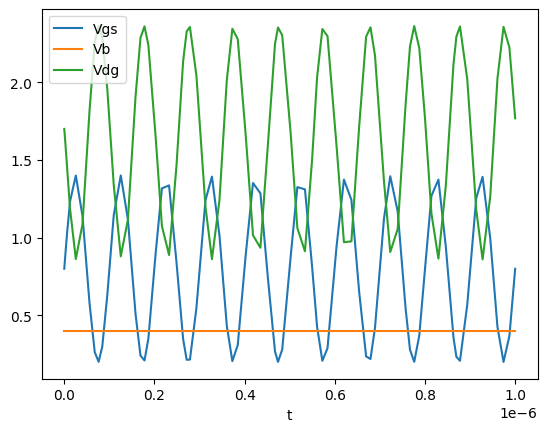

In [8]:
import csv
import pandas as pd

tb = '''
.include ICPS2023_5/Technology/tech/models/SOI_CMOS
.include proppy-amp_output.spice

Vground VSS 0 DC 0V
Vpower VDD VSS DC 2.6V
Vinput VIN VSS DC 0V SIN(0.8V 0.6V 10000000)
Vbias VBIAS VSS DC 0.4V

Xamp VDD VBIAS VOUT VIN VSS base_Rev0.93

.tran 1u 1u
.control
run
wrdata sim.out V(VIN, VSS) VBIAS V(VOUT, VIN)
quit
.endc
'''
with open('tb.spice', 'w') as f:
  f.write(tb)
!minimal-env/bin/ngspice -b tb.spice
with open('sim.out') as f:
  df = pd.read_csv('sim.out', delimiter=' ', skipinitialspace=True, names=['t', 'Vgs', 'Vb', 'Vdg'], usecols=[0, 1, 3, 5]).set_index('t')
df.plot()
df